# xlines of Python: machine learning

This notebook goes with [the blog post of the same name](http://ageo.co/xlines04).

We're going to go over a very simple machine learning exercise. We're using the data from the [2016 SEG machine learning contest](https://github.com/seg/2016-ml-contest).

In [1]:
import numpy as np
import matplotlib.pyplot as mpl
% matplotlib inline

import sklearn
sklearn.__version__

# Should be 0.18

'0.17.1'

## Read the data

`numpy` has a convenient function, `loadtxt` that can load a CSV file. It needs a file... and ours is on the web. That's OK, we don't need to download it, we can just read it by sending its text content to a `StringIO` object, which acts exactly like a file handle.

In [2]:
import requests
import io

r = requests.get('https://raw.githubusercontent.com/seg/2016-ml-contest/master/training_data.csv')  # 1

We can't just load it, because we only want NumPy to have to handle an array of floats and there's metadata in this file (we can't tell that, I just happen to know it... and it's normal for CSV files). 

[Pandas](http://pandas.pydata.org/) is really convenient for this sort of data.

In [3]:
import pandas as pd

df = pd.read_csv(io.StringIO(r.text))  # 2

df.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915

**I later learned that you can just do this...**

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/training_data.csv')

df.head()

<div style="margin-top:12px; padding: 12px; border:2px solid gray; border-radius:5px; background: #eeeeee;"><p>**A word about the data.** This dataset is not, strictly speaking, open data. It has been shared by the Kansas Geological Survey for the purposes of the contest. That's why I'm not copying the data into this repository, but instead reading it from the web. We are working on making an open access version of this dataset. In the meantime, I'd appreciarte it if you didn't replicate the data anywhere. Thanks!</p></div>

## Get the feature vectors, `X`

In [4]:
features = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']  # 3

Now we'll load the data we want. First the feature vectors, `X`. We'll just get the logs, which are in columns 4 to 8:

In [5]:
X = df[features].values  # 4

In [6]:
X.shape

(3232, 5)

## Get the label vector, `y`

In [7]:
y = df.Facies.values  # 5

In [8]:
y.shape

(3232,)

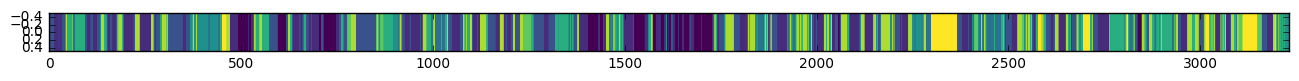

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 1))
plt.imshow(np.array([y]), cmap='viridis', aspect=100)
plt.show()

We have data! Almost ready to train, we just have to get our test / train subsets sorted.

## Extracting some training data

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)  # 6

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2424, 5), (2424,), (808, 5), (808,))

**Optional exercise:** Use [the docs for `train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to set the size of the test set, and also to set a random seed for the splitting.

Now the fun can really begin. 

## Training and evaluating a model

In [13]:
from sklearn.ensemble import ExtraTreesClassifier 

In [14]:
clf = ExtraTreesClassifier()  # 7

In [15]:
clf.fit(X_train, y_train)  # 8

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [16]:
clf.score(X_test, y_test)

0.6410891089108911

**Optional exercise:** Try changing some hyperparameters, eg `verbose`, `n_estimators`, `n_jobs`, and `random_state`

In [ ]:
clf = ExtraTreesClassifier(... HYPERPARAMETERS GO HERE ...)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

All models have the same API (but not the same hyperparameters), so it's very easy to try lots of models.

## Predict!

In [18]:
y_pred = clf.predict(X_test)  # 9

A quick score:

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.6410891089108911

The confusion matrix, showing exactly what kinds of mistakes (type 1 and type 2 errors) we're making:

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[ 50,  11,   0,   1,   0,   1,   0,   0,   0],
       [ 10, 145,  30,   2,   0,   1,   0,   2,   0],
       [  3,  35,  93,   2,   3,   2,   1,   1,   0],
       [  0,  15,   1,  22,   5,   7,   0,   3,   0],
       [  0,   3,   8,   3,  22,  16,   0,   7,   0],
       [  0,   9,   1,   3,   9,  71,   2,  18,   2],
       [  2,   5,   2,   0,   0,   1,  12,   2,   0],
       [  1,   9,   6,   2,   2,  31,   1,  69,   5],
       [  0,   0,   0,   1,   1,   0,   1,   1,  34]])

Finally, the classification report shows the type 1 and type 2 error rates (well, 1 - the error) for each facies, along with the combined, F1, score:

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))  # 10

             precision    recall  f1-score   support

          1       0.76      0.79      0.78        63
          2       0.62      0.76      0.69       190
          3       0.66      0.66      0.66       140
          4       0.61      0.42      0.49        53
          5       0.52      0.37      0.44        59
          6       0.55      0.62      0.58       115
          7       0.71      0.50      0.59        24
          8       0.67      0.55      0.60       126
          9       0.83      0.89      0.86        38

avg / total       0.64      0.64      0.64       808



## More in-depth evaluation: k-fold cross-validation

We should drop out entire wells, not just a bunch of random samples. Otherwise we're training on data that's just one sample away from data we're validating against.

To do this, we need a vector that contains an integer (or something) representing each unique well.

In [22]:
wells = df['Well Name']

In [23]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
clf = ExtraTreesClassifier(random_state=0)

for train, test in logo.split(X, y, groups=wells):
    # train and test are the indices of the data to use.
    well_name = wells[test[0]]
    clf.fit(X[train], y[train])
    score = clf.score(X[test], y[test])
    print("{:>20s}  {:.3f}".format(well_name, score))

     CHURCHMAN BIBLE  0.460
      CROSS H CATTLE  0.315
            LUKE G U  0.388
               NEWBY  0.376
               NOLAN  0.352
          Recruit F9  0.868
             SHANKLE  0.419
           SHRIMPLIN  0.524


<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">Â© Agile Geoscience 2016</p>
</div>